# Homework 1

## Group 10 

### 2 Learning a policy via 1-step SARSA

In [4]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import time

LEFT = 0
TOP = 1
RIGHT = 2
DOWN = 3

class GridWorld():
    def __init__(self, size=(5,6)):
        self.size = size
        self.board = np.zeros(size)
        self.board[4,3] = 1
        self.board[4,4] = -1
        self.state = (0,0)

    def get_size(self):
        return self.size

    def get_state(self):
        return self.state

    def get_reward(self):
        return self.board[self.state]

    def is_legal(self, next_state):
        if ((next_state[0] >= 0) and (next_state[0] < len(self.board))):
            if ((next_state[1] >= 0) and (next_state[1] < len(self.board[0]))):
                if(next_state != (2,2)):
                    return True 
                else: 
                    return False
    
    def is_goal(self):
        if (self.board[self.state] == -1) or (self.board[self.state] == 1):
            return True
        else: 
            return False

    def reset(self):
        self.state = (0,0)

    def move(self, action): 
        # origin at top left
        # TOP
        if action == TOP: 
            next_state = (self.state[0] - 1, self.state[1])
        # RIGHT
        if action == RIGHT:
            next_state = (self.state[0], self.state[1] + 1)
        # DOWN
        if action == DOWN:
            next_state = (self.state[0] + 1, self.state[1])
        # LEFT
        if action == LEFT:
            next_state = (self.state[0], self.state[1] -1)
        # check if move is legal
        if self.is_legal(next_state):
            self.state = next_state

class Agent():
    def __init__(self):
        self.grid_world = GridWorld()
        self.epsilon = 0.8
        self.decay = 0.99
        self.size = self.grid_world.get_size()
        self.q_values = np.random.uniform(low=0, high=1, size=(self.size[0], self.size[1], 4))
        self.q_values[4,3,:] = 0
        self.q_values[4,4,:] = 0
        self.returns = {}
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                for k in range(4):
                    self.returns[((i,j),k)] = []
    
    def get_action(self, s):
        if rd.random() < (1-self.epsilon + self.epsilon/4):
            return np.argmax(self.q_values[s[0], s[1], :])
        else:
            return np.random.randint(low=0, high=4)

    def mccontrol(self, n_episodes, gamma, vb = False, s_fixed = (0,0), a_fixed = 0):
        mean_return_episode = []
        time_per_episode = []
        moving_average = []
        q_value_fixed = []
        start = time.time()
        for _ in range(n_episodes):
            returns = []
            visited = []
            episode = []
            self.grid_world.reset()
            while(not self.grid_world.is_goal()):
                s = self.grid_world.get_state()
                a = self.get_action(s)
                self.grid_world.move(a)
                r = self.grid_world.get_reward()
                episode.append((s,a,r))
                returns.append(r)
            if not vb:
                self.epsilon *= self.decay
            G = 0
            for s,a,r in reversed(episode):
                G = gamma * G + r 
                if (s,a) not in visited and not vb:
                    self.returns[s,a].append(G)
                    self.q_values[s[0], s[1], a] = np.mean(self.returns[s,a])
                elif vb and s == s_fixed and a == a_fixed:
                    self.returns[s,a].append(G)
                    self.q_values[s[0], s[1], a] = np.mean(self.returns[s,a])
            mean_return_episode.append(np.mean(returns))
            moving_average.append(np.mean(mean_return_episode))
            time_per_episode.append(time.time()-start)
            q_value_fixed.append(self.q_values[s_fixed[0], s_fixed[1], a_fixed])
        if vb:
            return q_value_fixed
        else:
            return moving_average, time_per_episode
                
        



    def sarsa(self, n_episodes, alpha, gamma, vb = False, s_fixed = (0,0), a_fixed = 0):
        mean_return_episode = []
        time_per_episode = []
        moving_average = []
        q_value_fixed = []
        start = time.time()
        for _ in range(n_episodes):
            returns = []
            self.grid_world.reset()
            terminate = False
            if vb:
                s = s_fixed
                a = a_fixed
            else:
                s = self.grid_world.get_state()
                a = self.get_action(s)
        
            while not terminate:
                self.grid_world.move(a)
                r = self.grid_world.get_reward()
                s2 = self.grid_world.get_state()
                a2 = self.get_action(s2)
                if vb:
                    if s_fixed == s and a_fixed == a:
                        self.q_values[s[0], s[1], a] = self.q_values[s[0], s[1], a] + alpha * (r + gamma * self.q_values[s2[0], s2[1], a2] - self.q_values[s[0], s[1], a])
                elif not vb: 
                    self.q_values[s[0], s[1], a] = self.q_values[s[0], s[1], a] + alpha * (r + gamma * self.q_values[s2[0], s2[1], a2] - self.q_values[s[0], s[1], a])
                s = s2
                a = a2
                if self.grid_world.is_goal():
                    terminate = True
                returns.append(r)

            if not vb:
                self.epsilon *= self.decay
            mean_return_episode.append(np.mean(returns))
            moving_average.append(np.mean(mean_return_episode))
            time_per_episode.append(time.time()-start)
            q_value_fixed.append(self.q_values[s_fixed[0], s_fixed[1], a_fixed])
        
        if vb:
            return q_value_fixed 
        else:
            return moving_average, time_per_episode

            

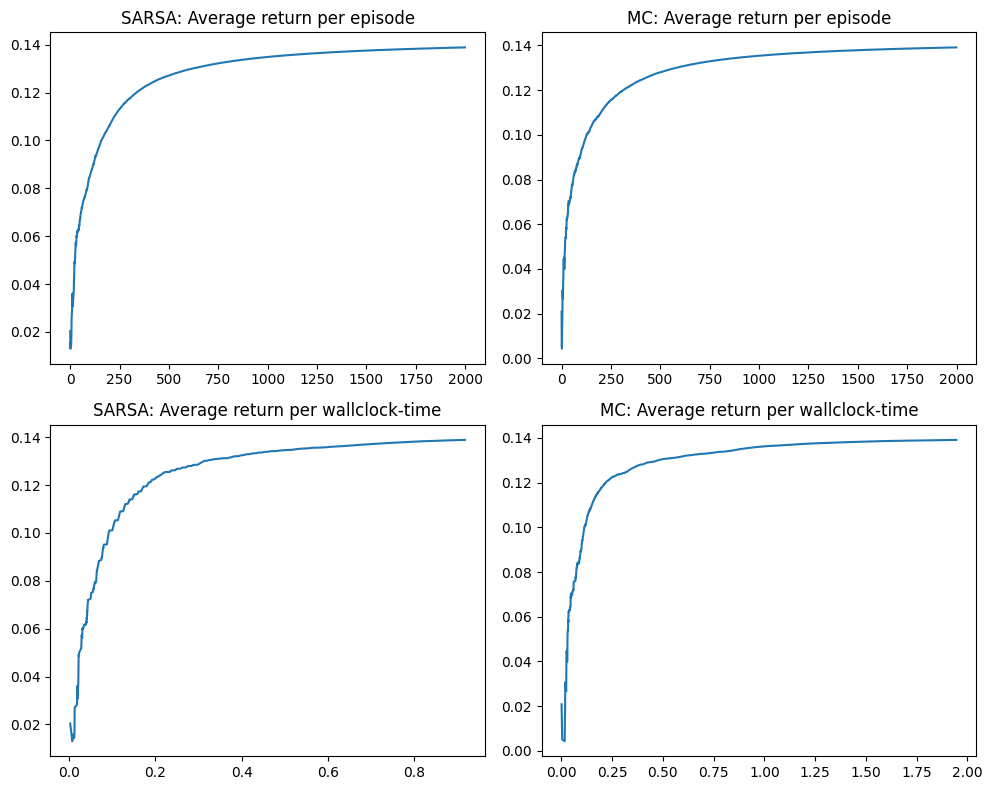

In [19]:
agent1 = Agent()
agent2 = Agent()

n_episodes = 2000
alpha = 0.25
gamma = 0.9

moving_average1, time_per_episode1= agent1.sarsa(n_episodes, alpha, gamma)
moving_average2, time_per_episode2= agent2.mccontrol(n_episodes, gamma)

fig, axs = plt.subplots(2,2)

axs[0][0].plot(np.arange(n_episodes),moving_average1)
axs[0][0].set_title("SARSA: Average return per episode")
axs[1][0].plot(time_per_episode1,moving_average1)
axs[1][0].set_title("SARSA: Average return per wallclock-time")

axs[0][1].plot(np.arange(n_episodes),moving_average2)
axs[0][1].set_title("MC: Average return per episode")
axs[1][1].plot(time_per_episode2,moving_average2)
axs[1][1].set_title("MC: Average return per wallclock-time")
fig.set_figheight(8)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

### 3 Visualizing Variance-Bias Trade-Off

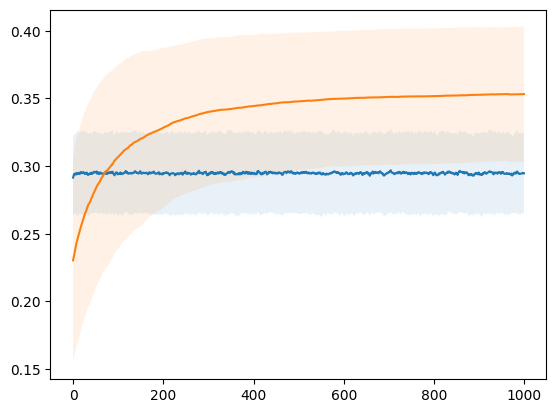

In [23]:
n_episodes = 50
alpha = 0.25
gamma = 0.9

q1 = []
q2 = []

for _ in range(100):
    sarsa_agent = Agent()
    mc_agent = Agent()

    _,_ = sarsa_agent.sarsa(n_episodes, alpha, gamma)
    _,_ = mc_agent.mccontrol(n_episodes, gamma)

    q1.append(sarsa_agent.sarsa(1000, alpha, gamma, vb = True, s_fixed = (0,0), a_fixed = 3))
    q2.append(mc_agent.mccontrol(1000, gamma, vb = True, s_fixed = (0,0), a_fixed = 3))


mean_q1 = np.mean(q1, axis=0)
std_q1 = np.std(q1, axis=0)

mean_q2 = np.mean(q2, axis=0)
std_q2 = np.std(q2, axis=0)

x = np.arange(1000)
plt.plot(x, mean_q1)
plt.fill_between(x, mean_q1-std_q1, mean_q1+std_q1, alpha = 0.1)
plt.plot(x, mean_q2)
plt.fill_between(x, mean_q2-std_q2, mean_q2+std_q2, alpha = 0.1)
plt.show()

The plot illustrates that MC-Control is an algorithm with higher variance and low bias and (1-step) SARSA is an algorithm with a high bias and low variance